# Performing raster and vector operations in Python using pyjeo

[pyjeo](https://jeodpp.jrc.ec.europa.eu/services/processing/pyjeohelp/) is the follow up of [PKTOOLS](http://pktools.nongnu.org/html/index.html), a suite of utilities written in C++ for image processing with a focus on remote sensing applications. It is distributed under a General Public License (GPLv3) as a Python package.

The examples in this notebook replicate the exercises on [pktools](http://spatial-ecology.net/docs/build/html/PKTOOLS/pktools_osgeo.html) in order to appreciate the difference and still analogy for those that are familiar with pktools.

In a nutshell, the main differences between pyjeo and pktools from a user's perspective are:

- pyjeo is a Python package should be run in a **Python environment**, whereas pktools applications are run from the command line (e.g., in a bash shell)
- pyjeo runs with images entirely **in memory**, whereas pktools runs most applications line per line. This makes pyjeo considerably faster, but with a larger memory footprint. However, there are some methods implemented in pyjeo to reduce the memory footprint by tiling the image

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

## Creating masks

**pktools**
We create three masks using different threshold values with [pkgetmask](http://pktools.nongnu.org/html/md_pkgetmask.html)

In [ ]:
%%bash
pkgetmask  -co COMPRESS=DEFLATE -co ZLEVEL=9 -min  1  -max  2 -data 1 -nodata 0 -ot Byte  -i  ../geodata/vegetation/ETmean08-11.tif  -o ../geodata/vegetation/ETmean08-11_01_trhA.tif
pkgetmask  -co COMPRESS=DEFLATE -co ZLEVEL=9 -min  5  -max  8 -data 1 -nodata 0 -ot Byte  -i  ../geodata/vegetation/ETmean08-11.tif  -o ../geodata/vegetation/ETmean08-11_01_trhB.tif
pkgetmask  -co COMPRESS=DEFLATE -co ZLEVEL=9 -min  0  -max  10 -data 0 -nodata 1 -ot Byte  -i  ../geodata/vegetation/ETmean08-11.tif  -o ../geodata/vegetation/ETmean08-11_01_trhC.tif

**pyjeo**

With pyjeo we create the masks in memory in a "pythonic" way using [get items](https://jeodpp.jrc.ec.europa.eu/services/processing/pyjeohelp/3_reference.html#get-jim-items) without the need to write temporary files.

In [ ]:
import pyjeo as pj

In [ ]:
fn = Path('../geodata/vegetation/ETmean08-11.tif')
jim = pj.Jim(fn)

#get mask
mask1 = (jim>=1) & (jim<=2)
mask2 = (jim>=5) & (jim<=8)
mask3 = (jim<0) | (jim>10)

## Applying masks

**pktools** 

Use the prepared mask and apply to the image with [pksetmask](http://pktools.nongnu.org/html/md_pksetmask.html)

In [ ]:
%%bash
pksetmask -co COMPRESS=DEFLATE -co ZLEVEL=9 \
-m ../geodata/vegetation/ETmean08-11_01_trhA.tif  -msknodata 1 -nodata  -9 \
-m ../geodata/vegetation/ETmean08-11_01_trhB.tif  -msknodata 1 -nodata  -5 \
-m ../geodata/vegetation/ETmean08-11_01_trhC.tif  -msknodata 1 -nodata -10 \
-i ../geodata/vegetation/ETmean08-11.tif -o ../geodata/vegetation/ETmean08-11_01_msk.tif

**pyjeo**

In pyjeo, we can apply the mask in a "pythonic" way using [set items](https://jeodpp.jrc.ec.europa.eu/services/processing/pyjeohelp/3_reference.html#set-jim-items)

In [ ]:
jim[mask1] = -9
jim[mask2] = -5
jim[mask3] = -10

However, we can even skip the intermediate step of creating the mask:

In [ ]:
jim = pj.Jim(fn)

jim[(jim<0) | (jim>10)] = -10
jim[(jim>=5) & (jim<=8)] = -5
jim[(jim>=1) & (jim<=2)] = -9

The result can then be written on disk if needed:

In [ ]:
jim.io.write('../geodata/vegetation/ETmean08-11_01_msk_pyjeo.tif', co = ['COMPRESS=DEFLATE', 'ZLEVEL=9'])

## Composite images

**pktools** 

Create a mask to apply during the composite

In [ ]:
%%bash
pkgetmask  -co COMPRESS=DEFLATE -co ZLEVEL=9 -min 0 -max 25 -data 0 -nodata 1 -ot Byte -i ../geodata/LST/LST_MOYDmax_month1.tif -o ../geodata/LST/LST_MOYDmax_month1-msk.tif

Calculate mean and standard deviation with several images with [pkcomposite](http://pktools.nongnu.org/html/md_pkcomposite.html)

In [ ]:
%%bash
pkcomposite $(for file in ../geodata/LST/LST_MOYDmax_month??.tif ../geodata/LST/LST_MOYDmax_month?.tif; do echo -i $file; done) \
-m ../geodata/LST/LST_MOYDmax_month1-msk.tif -msknodata 0 -cr mean   -dstnodata 0 \
-co  COMPRESS=LZW -co ZLEVEL=9 -o ../geodata/LST/LST_MOYDmax_monthMean.tif

pkcomposite $(for file in ../geodata/LST/LST_MOYDmax_month?.tif ../geodata/LST/LST_MOYDmax_month??.tif; do echo -i $file; done) \
-m ../geodata/LST/LST_MOYDmax_month1-msk.tif -msknodata 0 -cr stdev   -dstnodata -1 \
-co  COMPRESS=LZW -co ZLEVEL=9 -o ../geodata/LST/LST_MOYDmax_monthStdev.tif

An alternative way is to use [pkstatprofile](http://pktools.nongnu.org/html/pkstatprofile.html)

In [ ]:
%%bash
# Create a multiband vrt
gdalbuildvrt -overwrite -separate ../geodata/LST/LST_MOYDmax_month.vrt ../geodata/LST/LST_MOYDmax_month?.tif ../geodata/LST/LST_MOYDmax_month??.tif
# Calculate mean and standard deviation
pkstatprofile -co  COMPRESS=LZW -nodata 0 -f mean -f stdev  -i ../geodata/LST/LST_MOYDmax_month.vrt -o ../geodata/LST/LST_MOYDmax_month_mean_stdev.tif

**pyjeo**

In pyjeo, we can can composite images using [reducePlane](https://jeodpp.jrc.ec.europa.eu/services/processing/pyjeohelp/3_reference.html?highlight=reduceplane#geometry._Geometry.reducePlane)

In [ ]:
# iterate over files in
# that directory
files1 = sorted(Path('../geodata/LST/').glob('LST_MOYDmax_month?.tif'))
files2 = sorted(Path('../geodata/LST/').glob('LST_MOYDmax_month??.tif'))

#create single band multi-plane image
mask = None
jim = None
for file in files1:
    if jim is None:
        jim = pj.Jim(file)
        mask = (jim >= 0) & (jim <= 25)
    else:
        jim.geometry.stackPlane(pj.Jim(file))
for file in files2:
    jim.geometry.stackPlane(pj.Jim(file))

jim[mask] = 0
mean = pj.geometry.reducePlane(jim, rule = 'mean', nodata = 0)

**Briding pyjeo to Numpy**

Pyjeo has been designed to allow for [bridging](https://jeodpp.jrc.ec.europa.eu/services/processing/pyjeohelp/2_tutorial.html#bridging-jim-to-third-party-packages) Jim raster image objects to third party libraries such as Numpy.

We will re-use the mask Jim object to store the results.

In [ ]:
import numpy as np

mask.pixops.convert('GDT_Float32')
jim.np()[jim.np()==0] = np.nan

mask.np()[:] = np.nanmean(jim.np(), axis=0)
mask.geometry.stackBand(mask)
mask.np(1)[:] = np.nanstd(jim.np(), axis=0)

We can avoid NaN in the resulting image by replacing it with 0

In [ ]:
mask.np()[:] = np.nan_to_num(np.nanmean(jim.np(), axis=0), nan=0)
mask.np(1)[:] = np.nan_to_num(np.nanstd(jim.np(), axis=0), nan=0)

Even better is to avoid duplication of data to reduce memory footprint

In [ ]:
mask.np()[:] = np.nan_to_num(np.nanmean(jim.np(), axis=0), copy = False, nan=0)
mask.geometry.stackBand(mask)
mask.np(1)[:] = np.nan_to_num(np.nanstd(jim.np(), axis=0), copy = False, nan=0)

In [ ]:
plt.gray()  # show the filtered result in grayscale
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(131)  # left side
ax2 = fig.add_subplot(132)  # right side
ax3 = fig.add_subplot(133)  # right side
ax1.imshow(jim.np()[0,:,:])
ax2.imshow(mask.np(0))
ax3.imshow(mask.np(1))
plt.show()

Using tiling mechanism

In [94]:
tiletotal = 4
overlap = 0
def reduceTile(tileindex):
    mask = None
    jim = None
    for file in files1:
        if jim is None:
            jim = pj.Jim(file, tileindex = tileindex, tiletotal = tiletotal, overlap = overlap)
            mask = (jim >= 0) & (jim <= 25)
        else:
            jim1 = pj.Jim(file, tileindex = tileindex, tiletotal = tiletotal, overlap = overlap)
            jim.geometry.stackPlane(jim1)
    for file in files2:
        jim1 = pj.Jim(file, tileindex = tileindex, tiletotal = tiletotal, overlap = overlap)
        jim.geometry.stackPlane(jim1)

    jim[mask] = 0
    return pj.geometry.reducePlane(jim, rule = 'mean', nodata = 0)

<Figure size 432x288 with 0 Axes>

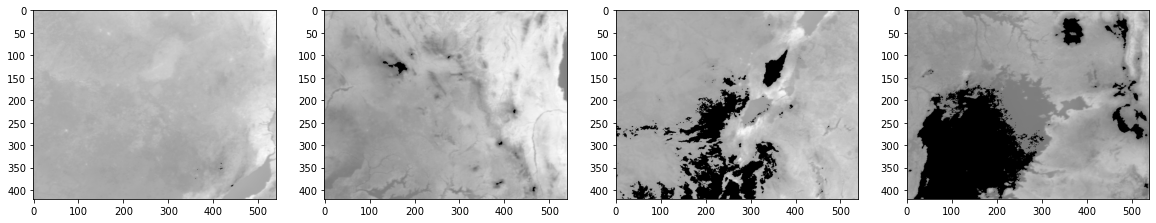

In [95]:
plt.gray()  # show the filtered result in grayscale
fig = plt.figure(figsize=(20,20))
ax = []
ax.append(fig.add_subplot(141))
ax.append(fig.add_subplot(142))
ax.append(fig.add_subplot(143))
ax.append(fig.add_subplot(144))

for tileindex in range(4):
    ax[tileindex].imshow(reduceTile(tileindex).np())
plt.show()

## Filter images

**pktools** 

Aggregating and filtering images using [pkfilter](http://pktools.nongnu.org/html/pkfilter.html)

In [ ]:
%%bash
# mean aggregation 
pkfilter -co COMPRESS=DEFLATE -co ZLEVEL=9 -nodata 0 -ot Float32 -dx 10 -dy 10 -f mean -d 10 -i ../geodata/LST/LST_MOYDmax_monthMean.tif -o ../geodata/LST/LST_MOYDmax_monthMean_aggreate10mean.tif
# mean circular moving window
pkfilter -co COMPRESS=DEFLATE -co ZLEVEL=9 -nodata 0 -ot Float32 -dx 11 -dy 11 -f mean -circ  -i ../geodata/LST/LST_MOYDmax_monthMean.tif -o ../geodata/LST/LST_MOYDmax_monthMean_circular11mean.tif

**pyjeo**

In pyjeo, we can can use [filter](https://jeodpp.jrc.ec.europa.eu/services/processing/pyjeohelp/3_reference.html?highlight=filter2d#ngbops._NgbOps.filter2d) method, but more functions are available via bridging pyjeo to third party libraries such as [scipy]()

In [ ]:
import pyjeo as pj
from pathlib import Path
from scipy import ndimage
import numpy as np
fn = Path('../geodata/LST/LST_MOYDmax_monthMean.tif')
jim = pj.Jim(fn)
taps = np.ones((10, 10))
mean = pj.ngbops.firfilter2d(jim, taps=taps, norm=True, pad='symmetric')
print(mean.properties.nrOfCol(), mean.properties.nrOfRow())
mean = mean[::10,::10]
print(mean.properties.nrOfCol(), mean.properties.nrOfRow())

In [ ]:
plt.gray()  # show the filtered result in grayscale
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side
ax1.imshow(jim.np())
ax2.imshow(mean.np())
plt.show()

In [ ]:
def unit_circle(r):
    A = np.arange(-r,r+1)**2
    dists = np.sqrt(A[:,None] + A)
    return (dists<=r).astype(int)
unit_circle(10)

In [ ]:
mean = pj.ngbops.firfilter2d(jim, taps=unit_circle(10), norm=True, pad='symmetric')

In [ ]:
plt.gray()  # show the filtered result in grayscale
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side
ax1.imshow(jim.np())
ax2.imshow(mean.np())
plt.show()

More functions are available via bridging pyjeo to third party libraries such as Multidimensional image processing from [scipy](https://docs.scipy.org/doc/scipy/tutorial/ndimage.html)

## Images statistics

**pktools** 

Aggregating and filtering images using [pkstat](http://pktools.nongnu.org/html/pkstat.html)

In [ ]:
%%bash
pkstat -hist  -src_min 0  -i ../geodata/temperature/ug_bio_3.tif > ../geodata/temperature/ug_bio_3.hist
head ../geodata/temperature/ug_bio_3.hist

In [ ]:
%%bash
pkstat -hist  -nbin  20 -src_min 0  -i    geodata/vegetation/GPPstdev08-11.tif

**pyjeo**

In pyjeo, we can can use [getStats](https://jeodpp.jrc.ec.europa.eu/services/processing/pyjeohelp/3_reference.html?highlight=getstats#stats._Stats.getStats)

In [ ]:
fn = Path('../geodata/temperature/ug_bio_3.tif')
jim = pj.Jim(fn)
stats = jim.stats.getStats('histogram', src_min = 0)
print(stats['bin'][0:10])
print(stats['histogram'][0:10])

In [ ]:
fn = Path('../geodata/vegetation/GPPstdev08-11.tif')
jim = pj.Jim(fn)
stats = jim.stats.getStats('histogram', src_min = 0, nbin = 20)
for index, bin in enumerate(stats['bin']):
    print(bin, stats['histogram'][index])

In [ ]:
fig = plt.figure(figsize = (10, 5))
plt.bar(stats['bin'],stats['histogram'])
plt.xlabel("pixel value")
plt.ylabel("abs frequency")
plt.title("Histogram of pixel values")
plt.show()

## Images reclassification

**pktools** 

Aggregating and filtering images using [pkreclass](http://pktools.nongnu.org/html/pkreclass.html)

In [ ]:
%%bash
pkstat -hist -i ../geodata/temperature/ug_bio_3.tif | grep -v " 0" | awk '{ if ($1<75) {print $1, 0} else {print $1 , 1}}' > ../geodata/temperature/reclass_ug_bio_3.txt
pkreclass -co COMPRESS=DEFLATE -co ZLEVEL=9 -code ../geodata/temperature/reclass_ug_bio_3.txt -i ../geodata/temperature/ug_bio_3.tif  -o ../geodata/temperature/reclass_ug_bio_3.tif

**pyjeo**

In pyjeo, we can can use [reclass](https://jeodpp.jrc.ec.europa.eu/services/processing/pyjeohelp/3_reference.html?highlight=reclass#classify._Classify.reclass)

In [ ]:
fn = '../geodata/temperature/ug_bio_3.tif'
jim = pj.Jim(fn)
print(jim.properties.getDataType())
print(jim.stats.getStats())
stats = jim.stats.getStats('histogram')

for index, bin in enumerate(stats['bin']):
    if stats['histogram'][index] > 0:
        print(bin, stats['histogram'][index])

if -9999 in jim.np():
    print("value -9999 is found")
classes0 = [c for c in stats['bin'] if stats['histogram'][stats['bin'].index(c)] > 0 and c < 75]
classes1 = [c for c in stats['bin'] if stats['histogram'][stats['bin'].index(c)] > 0 and c >= 75]
reclasses0 = np.zeros_like(classes0).tolist()
reclasses1 = np.ones_like(classes1).tolist()
print(classes0 + classes1)
print(reclasses0 + reclasses1)

reclass = pj.classify.reclass(jim, classes = classes0 + classes1, reclasses = reclasses0 + reclasses1)

However, we can do it much simpler:

In [ ]:
jim[jim < 75] = 0
jim[jim >= 75] = 1
print(reclass.properties.isEqual(jim))

## Zonal statistic (polygon extraction)

**pktools** 

Aggregating and filtering images using [extractogr](http://pktools.nongnu.org/html/pkextractogr.html)

In [ ]:
%%bash
rm -f geodata/shp/polygons_stat.*
pkextractogr -srcnodata -339999995214436424907732413799364296704   -r mean -r stdev -r min -i ../geodata/vegetation/GPPmean08-11.tif -s ../geodata/shp/polygons.sqlite -o ../geodata/shp/polygons_stat.sqlite
pkextractogr -f "ESRI Shapefile" -srcnodata -339999995214436424907732413799364296704   -r mean -r stdev -r min -i ../geodata/vegetation/GPPmean08-11.tif -s ../geodata/shp/polygons.sqlite -o ../geodata/shp/polygons_stat.shp

# we can also create a csv that can be manipulate later on with awk
rm  -f ../geodata/shp/polygons_stat.csv
pkextractogr -f CSV -srcnodata -339999995214436424907732413799364296704   -r mean -r stdev -r min -i ../geodata/vegetation/GPPmean08-11.tif -s ../geodata/shp/polygons.sqlite -o ../geodata/shp/polygons_stat.csv

**Zonal statistic (point extraction)**

In [ ]:
%%bash 
# at point location
rm -f ../geodata/shp/point_stat.csv
pkextractogr -f CSV -srcnodata -339999995214436424907732413799364296704 -r mean -r stdev -r min -i ../geodata/vegetation/GPPmean08-11.tif -s ../geodata/shp/presence.shp -o ../geodata/shp/point_stat.csv
# at point location + 1 pixel around 
rm -f ../geodata/shp/point-buf_stat.csv
pkextractogr -f CSV -buf 2 -srcnodata -339999995214436424907732413799364296704 -r mean -r stdev -r min -i ../geodata/vegetation/GPPmean08-11.tif -s ../geodata/shp/presence.shp -o ../geodata/shp/point-buf_stat.csv

**pyjeo**

In pyjeo, we can can use [extract](https://jeodpp.jrc.ec.europa.eu/services/processing/pyjeohelp/3_reference.html#geometry._GeometryVect.extract)

output in SQLite format

In [ ]:
fn = '../geodata/vegetation/GPPmean08-11.tif'
vfn = '../geodata/shp/polygons.sqlite'
jim = pj.Jim(fn)
jim[jim<0]=-1
print(jim.stats.getStats())
v = pj.JimVect(vfn)
output = '../geodata/shp/temp.sqlite'
Path(output).unlink(missing_ok = True)
extracted1 = pj.geometry.extract(v, jim, rule=['mean', 'stdev', 'min'], output=output, srcnodata = -1)

output in ESRI Shapefile format

In [ ]:
output = '../geodata/shp/temp.shp'
Path(output).unlink(missing_ok = True)
extracted2 = pj.geometry.extract(v, jim, rule=['mean', 'stdev', 'min'], output='../geodata/shp/temp.shp', oformat='ESRI Shapefile', srcnodata = -1)

calculate in memory and get result in dictionary

In [ ]:
extracted3 = pj.geometry.extract(v, jim, rule=['allpoints'], output='temp1', oformat='Memory', srcnodata = -1)
print(extracted3.dict())

In pandas format

In [ ]:
print(pd.DataFrame(extracted3.dict()))

Extract point data

In [ ]:
vfn = '../geodata/shp/presence.shp'
v = pj.JimVect(vfn)
extracted4 = pj.geometry.extract(v, jim, rule=['mean'], output='point', oformat='Memory', srcnodata = -1)

Extract points with buffer to calculate mean and standard deviation and minimum

In [ ]:
buffer = jim.properties.getDeltaX()*1
extracted5 = pj.geometry.extract(v, jim, rule=['mean', 'stdev', 'min'], output='point_buf', oformat='Memory', srcnodata = -1, buffer = buffer)
print("In pandas format")
print(pd.DataFrame(extracted5.dict()))

**Remove all the output**

In [ ]:
%%bash
rm -f  ../geodata/vegetation/GPPcv08-11.tif ../geodata/LST/*_crop.tif ../geodata/vegetation/ETmean08-11_crop_trh.tif ../geodata/vegetation/ETmean08-11_crop_trh.txt ../vegetation/ETmean08-11_crop.txt ../geodata/vegetation/ETmosaic.vrt ../geodata/vegetation/ETmosaic.tif ../geodata/vegetation/stack_??.tif../geodata/vegetation/stack.vrt../geodata/vegetation/tiles.*../geodata/vegetation/ETmean08-11_crop_proximity.tif../geodata/vegetation/ETmean08-11_crop_buffer.tif ../geodata/dem/slope.tif../geodata/dem/aspect.tif ../geodata/dem/tri.tif../geodata/dem/tpi.tif../geodata/dem/roughness.tif../geodata/vegetation/ETmean08-11_01_trh?.tif../geodata/LST/LST_MOYDmax_month1-msk.tif../geodata/LST/LST_MOYDmax_monthStdev.tif../geodata/LST/LST_MOYDmax_monthMean.tif../geodata/LST/LST_MOYDmax_month_mean_stdev.tif../geodata/LST/LST_MOYDmax_month.vrt../geodata/LST/LST_MOYDmax_monthMean_aggreate10mean.tif../geodata/LST/LST_MOYDmax_monthMean_circular11mean.tif ../geodata/temperature/reclass_ug_bio_3.tif../geodata/temperature/reclass_ug_bio_3.txt../geodata/shp/polygons_stat.csv../geodata/shp/point-buf_stat.csv../geodata/shp/point_stat.csv../geodata/shp/polygons_stat.*../geodata/shp/TM_LARGE_BORDERS.shp.* ../geodata/shp/TM_UGANDA_BORDERS-0.3.* ../geodata/vegetation/ETmean08-11_crop.txt ../geodata/vegetation/ETmean08-11_01_msk_pyjeo.tif ../geodata/shp/temp.*